In [3]:
#Preamble
import ipywidgets as widgets
import io
import os
import pandas as pd
import requests
from matplotlib.pyplot import *
import rpy2
import rpy2.robjects as robjects
import numpy
import textwrap

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)




# **Sample Analysis**
### Introduction
This notebook will help you answer the question of "Does a certain kind of police activity happen disproportionately (as compared to the town's population) to different racial groups?"

### **Step #0:** Lets get some census data to compare to

If you have a CSV with the racial makeup of your town, upload that. Otherwise, we (eventually) will automatically pull census data.

Usually this can easily be found by going to http://data.census.gov and typing your town's name in the search bar.  Then, select the 'RACE' data file, and click 'CSV' to download a CSV.

In [15]:
robjects.r('''
        # create a function `fetchCensusRaceData`
        fetchCensusRaceData <- function(state,county) {
            c(state,county)
        }
        ''')
r_FetchCensusRaceData = robjects.r['fetchCensusRaceData']

In [ ]:
%matplotlib inline


selectCensusDataMethod = widgets.RadioButtons(
    options=['I have a CSV', 'Fetch census data for me'],
#    layout={'width': 'max-content'}, # If the items' names are long
    description='Do you already have demographic data?',
)

#for later use
censusRaceDropDown = widgets.Dropdown()

def load_data0():
    global townRace
    #townRaceRaw = pd.read_csv(os.path.join("data/",fileSelect0.value),index_col=[0])
    townRaceRaw = pd.read_csv(io.BytesIO(fileUpload0.value[-1].content),index_col=[0])
    townRaceRaw.columns=['Population']
    townRaceRaw['Population']=townRaceRaw['Population'].apply(lambda s: s.replace(',',''))
    townRaceRaw['Population']=townRaceRaw['Population'].astype('int')
    totalTownPopulation = townRaceRaw.filter(like='Total',axis='index').iloc[0,0]
    townRace = pd.DataFrame([["White",townRaceRaw.filter(like='White',axis='index')['Population'].sum()],
                          ["Black or African American", townRaceRaw.filter(like='Black',axis='index')['Population'].sum()],
                          ["American Indian or Alaskan Native", townRaceRaw.filter(like='American Indian',axis='index')['Population'].sum()],
                          ["Asian", townRaceRaw.filter(like='Asian',axis='index')['Population'].sum()],
                          ["Native Hawaiian or Other Pacific Islander",townRaceRaw.filter(like='Native Hawaiian',axis='index')['Population'].sum()],
                          ["Some Other Race", townRaceRaw.filter(like='Other',axis='index')['Population'].sum()]])
    townRace.columns=['Race','Population']
    townRace['Percentage']=townRace['Population']/totalTownPopulation

    censusRaceDropDown.options=townRace['Race']
    with outputWidget4:
        display(censusRaceDropDown)
    
    with outputWidget0:
        display("Successfully loaded the datafile " + fileUpload0.value[-1].name)
        display("The total population of your town is " + str(totalTownPopulation))
        townRace.plot.bar(x='Race',y='Percentage')
        show()

outputWidget0 = widgets.Output(layout={'border': '1px solid black'})
fileUpload0 = widgets.FileUpload()
fileUpload0.observe(lambda b: load_data0(), names='value')

def selection():
    outputWidget0.clear_output()
    with outputWidget0:
        display("You have chosen "+selectCensusDataMethod.value)
        if selectCensusDataMethod.value == 'I have a CSV':
            display(fileUpload0)
        if selectCensusDataMethod.value == 'Fetch census data for me':
            display(r_FetchCensusRaceData("AL","Mobile"))
            
selectCensusDataMethod.observe(lambda b: selection(), names='value')
#Make sure our event handler runs the first time 
selection()

display(selectCensusDataMethod)
display(outputWidget0)

### **Step #1:** Load the police data

Upload a CSV file containing your police data here.

In [4]:
outputWidget = widgets.Output(layout={'border': '1px solid black'})

fileUpload1 = widgets.FileUpload()
display(fileUpload1)

outputWidget3 = widgets.Output(layout={'border': '1px solid black'})
raceDropDown=widgets.Dropdown()
def load_data():
    global arrests
    arrests = pd.read_csv(io.BytesIO(fileUpload1.value[-1].content),index_col=[0])
    global raceDropDown
    raceDropDown.options=arrests.columns
    with outputWidget3:
        display(raceDropDown)
    
    with outputWidget:
        display("Successfully loaded the datafile " + fileUpload1.value[-1].name )

fileUpload1.observe(lambda b: load_data(), names='value')
display(outputWidget)

Dropdown(options=('Durham_arrests_charges.csv', 'Durham_census_race_table.csv'), value='Durham_arrests_charges…

Button(description='Load data file', style=ButtonStyle())

Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

<IPython.core.display.Javascript object>

If you would like to preview your data, select how many rows you would like to preview from the dropdown.

In [5]:
outputWidget2 = widgets.Output(layout={'border': '1px solid black'})
# Take a first look:
numRows = widgets.Dropdown(
    options=['5', '10', '15', '20'],
    description='Number:',
    disabled=False,
)
display(numRows)
def preview_data():
    outputWidget2.clear_output()
    with outputWidget2:
        display(arrests.sample(int(numRows.value)))
numRows.observe(lambda b: preview_data(), names='value')
display(outputWidget2)

Dropdown(description='Number:', options=('5', '10', '15', '20'), value='5')

Button(description='Preview', style=ButtonStyle())

Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

### **Step #2:** Which column has the racial data?

Which of these columns represents the race of the person described in the police report? 

In [ ]:
%matplotlib inline
#display(columnsButton,outputWidget3)
display(outputWidget3)

#For later use
policeRaceSelectMultiple = widgets.SelectMultiple()
def raceDropdownChange():
    policeRaceSelectMultiple.options = arrests.groupby(raceDropDown.value).groups.keys()
    with outputWidget4:
        display(policeRaceSelectMultiple)
    with outputWidget3:
        arrests[raceDropDown.value].value_counts(normalize=True).plot.bar()
        show()
raceDropDown.observe(lambda b: raceDropdownChange(),names='value')

In order to compare, we need to somehow match up Census racial categories with police racial categories.
Select a census racial category from the dropdown, and then select which categories from the police data should match to it.
When finished, click the button to confirm.

In [ ]:
#May refactor later. Here is a first go
outputWidget4 = widgets.Output(layout={'border': '1px solid black'})

#Make a dropdown for race categories from census
raceMapDict={}
def policeSelectChange():
    global raceMapDict
    with outputWidget4:
        raceMapDict[censusRaceDropDown.value]=policeRaceSelectMultiple.value
        
        if policeRaceSelectMultiple.value:
            display("Police categories " + " and ".join(policeRaceSelectMultiple.value) + " are now mapped to " + censusRaceDropDown.value)
        else:
            display("No police categories are mapped to "+censusRaceDropDown.value)

policeRaceSelectMultiple.observe(lambda b: policeSelectChange(), names='value')

display(outputWidget4)

In [ ]:
outputWidget5 = widgets.Output(layout={'border': '1px solid black'})

dictButton = widgets.Button(
    description='Click to confirm mapping of categories',
)

display(dictButton)

def displayDict():
    outputWidget5.clear_output()
    with outputWidget5:
        #Check if they accidentally mapped a category multiple places
        for x in set([ item for l in raceMapDict.values() for item in l]):
            if [ item for l in raceMapDict.values() for item in l].count(x)> 1:
                display("Warning: " + str(x) + " is mapped to multiple categories")
        #Display the mapping for verification
        for key in raceMapDict.keys():
            display(key +" is mapped to " + " and ".join(raceMapDict[key]))

    #with outputWidget6:
        X = raceMapDict.keys()
        #Ygirls = [10,20,20,40]
        Ytown=[]
        Ypolice=[]
        townRace.set_index('Race', inplace = True)
        for key in X:
            Ytown.append(townRace.loc[key,'Percentage'])
            Ypolice.append(sum([arrests[raceDropDown.value].value_counts(normalize=True)[v] for v in raceMapDict[key]]))
            #Y2.append()
        #display(Y1)
        #display(Y2)
        # Zboys = [20,30,25,30]
        # #Y2=

        X_axis = numpy.arange(len(X))
        
        matplotlib.pyplot.bar(X_axis - 0.2, Ytown, 0.4, label = 'Town')
        matplotlib.pyplot.bar(X_axis + 0.2, Ypolice, 0.4, label = 'Police encounters')
        
        f = lambda x: textwrap.fill(x, 10)
        matplotlib.pyplot.xticks(X_axis, map(f,X))
        matplotlib.pyplot.xlabel("Race")
        matplotlib.pyplot.ylabel("Percentage")
        matplotlib.pyplot.title("Comparison of town demographics to police encounters")
        matplotlib.pyplot.legend()
        matplotlib.pyplot.show()
dictButton.on_click(lambda b: displayDict())


display(outputWidget5)

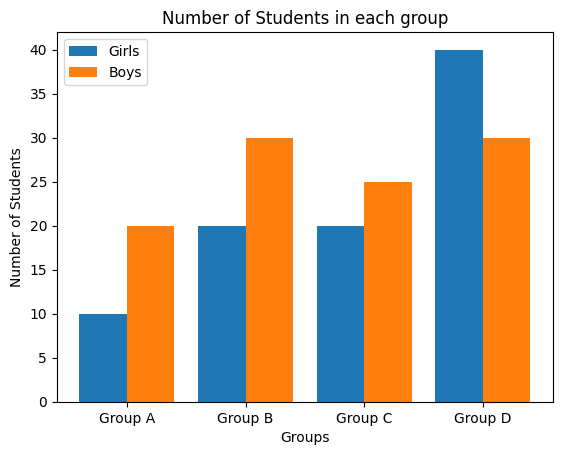

In [7]:
%matplotlib inline


outputWidget6 = widgets.Output(layout={'border': '1px solid black'})
display(outputWidget6)
#X = ['Group A','Group B','Group C','Group D']

